Primero importamos las librerías necesarias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score,roc_auc_score, average_precision_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint
#from scikitplot.metrics import plot_lift_curve,plot_cumulative_gain #!pip install scikit-plot
import warnings
warnings.filterwarnings("ignore")

Ahora importe los datos para guardarlos como un "Data frame" y poder usarlos aquí en el Notebook. Primero debe dar click a la celda de abajo que se encuentra vacía. Luego abra el panel derecho dando click en el siguiente ícono que se encuentra arriba a la derecha:

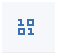

Después que cargue deberá ver los archivos csv que previamente a cardagos. Busque "Churn_Modeling.csv", de click en "Insert to code" y luego "Insert pandas DataFrame"

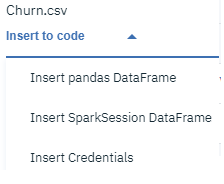


Asegurate de que el data frame creado tenga el  nombre df_data_1, de lo contrario corrigelo.

Corre la celda.




El problema de taza de abandono de un banco tiene la particularidad de que del total de clientes solo un pequeño porcentaje es el que abandona el banco. En otras palabas, la variable "Exited" tiene muchos más "0" que "1". Para observar este comportamiento observemos la siguiente gráfica.

In [ ]:
#Gráfica de variable a predecir
churn_count=sns.countplot(df_data_1.Exited)
churn_count.set(xlabel="¿El cliente abandonó el banco?",ylabel="Número de clientes",title="Distribución del abandono")
plt.show()

print('Taza de abandono = ',str(100*sum(df_data_1.Exited==1)/len(df_data_1.Exited))+"%")

Ahora se van a hacer los últimos paso de procesamiento de datos. Primero debemos separar los datos en las
matrices X,y. En "X" se guardan todas las variables que se van a usar para poder predecir y en "y"se guarda
la variable "Exited" que es la que queremos predecir. 

Los aloritmos de machine learning no entienden bien cuando las variables son texto (Como es el caso de las variables "Geography" y "Gender". Para esto se usa una técnica llamada "Label encoding" que consiste en transformar cada palabra única de las variables a un número. Por ejemplo, en la variable "Geography" se podría convertir France a 1 y Spain a 2. 

Finalmente, se separan los datos en dos conjuntos: uno de entrenamiento y otro de prueba.

In [ ]:
##Se crean las matrices X,y.
X=df_data_1.drop('Exited',axis=1)#Eliminamos columnas
y=df_data_1.Exited#Definimos variable a predecir


##Se define función que crea diccionarios para transformar los factores de las variables categóricas a números y viceversa.
def label_encoder(X,cols):
    from collections import namedtuple
    encode={}
    decode={}
    for i in cols:
        le=LabelEncoder()
        le.fit_transform(X[i])
        encode[i]=dict(zip(le.classes_, le.transform(le.classes_)))
        decode[i]=dict(zip(le.transform(le.classes_),le.classes_))
    encoder_tuple = namedtuple('encoder_tuple', ['encode', 'decode'])
    dictionaries=encoder_tuple(encode,decode)
    return(dictionaries)


categoric=X.select_dtypes(include=['object']).columns#Guarda el nombre de las columnas categóricas.

dictionaries=label_encoder(X,categoric)#Label encoder dictionaries
X.replace(dictionaries.encode,inplace=True)#Codificamos las variables categóricas.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=0)#Dividimos los datos en entrenamiento y prueba.

m,n=X_train.shape#Extraemos las dimensiones de la matriz X de entrenamiento.

X.head()#Observamos cómo quedan las primeras 5 filas luego de la transformación.

En esta sección se corre el algoritmo que determinará el modelo.

Los modelos de machine learning requieren de ciertos parámetros que el usuario debe ingresar. Sin embargo, hacer esto a mano no es nada práctico por lo que existen diferentes métodos para "automatizar" el proceso.
El método usado a continuación se llama "búsqueda aleatoria". Para esto simplemente se seleccionan los parámetros que se quieren sintonizar y se establecen rangos de valores en los que se quieren que estén los parámetros. El valor que toma cada variable es tomado aleatoriamente de este este rango en cada iteración.

Finalmente, se calcula la exactitud de los diferentes modelos y se escogen los parámetros del modelo con mejor exactitud.

In [ ]:
param_dist = {"max_features": sp_randint(int(np.sqrt(n)), int(3*n/4)),
              "min_samples_leaf": sp_randint(1, 20)}#Se definen los hiperparámetros para sintonizar el modelo

clf= RandomForestClassifier(n_jobs=-1,n_estimators=#COLOCAR AQUÍ NÚMERO DE ÁRBOLES) #Se inicializa la instancia de Random Forest.

#Corre búsqueda aleatorio por X iteraciones.
n_iter_search = #COLOQUE AQUÍ EL NÚMERO DE ITERACIONES
random_search_clf= RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search,cv=5,scoring="accuracy",random_state=10)

random_search_clf.fit(X_train, y_train)#Se entrena el modelo con los mejores parámetros encontrados.

best_estimator=random_search_clf.best_estimator_#Guarda el modelo.
best_score=random_search_clf.best_score_#Guarda el puntaje del mejor modelo

print(' Best params:',best_estimator,'\n','Best score:',best_score)

Ya que el modelo está entrenado, procedemos a probarlo en el conjunto de prueba.
Para esto realizamos las predicciones de estos datos y luego comparamos con los resultados reales.
Esta comparación se hace de acuerdo a varias métricas.

In [ ]:
y_pred=best_estimator.predict(X_test)#Predicciones binarias en el conjunto de prueba
y_pred_proba=best_estimator.predict_proba(X_test)#Predicciones de probabilidad en el conjunto de prueba

accuracy=accuracy_score(y_pred=y_pred,y_true=y_test)#Exactitud
AUC=roc_auc_score(y_score=y_pred_proba[:,1],y_true=y_test)#AUC
average_precision_score=  average_precision_score(y_true=y_test,y_score=y_pred_proba[:,1])

print('Accuracy:'+str(np.round(accuracy*100,4))+"%","\t",'AUC:'+str(np.round(AUC*100,4))+"%","\t"
     ,'average_precision_score:'+str(np.round(average_precision_score*100,4))+"%","\t")

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------

# Crear un API del modelo

Se importan los respositorios de machine learning.

In [ ]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

Se guardan las credenciales del servicio de machine learning en un JSON para luego usar esta información.

In [ ]:
wml_credentials= 

Se autentica el servicio con las credenciales.

In [ ]:
client = WatsonMachineLearningAPIClient( wml_credentials )

Guardamos el modelo en la instancia del servicio de machine learning

In [ ]:
metadata = {
client.repository.DefinitionMetaNames.NAME              : "**DALE UN NOMBRE AL MODELO**",
client.repository.DefinitionMetaNames.FRAMEWORK_NAME    : "scikit-learn",
client.repository.DefinitionMetaNames.RUNTIME_NAME      : "python",
client.repository.DefinitionMetaNames.RUNTIME_VERSION   : "3.6"
}

stored_model_details = client.repository.store_model(best_estimator,meta_props=metadata)
print( "stored_model_details: ", stored_model_details )
model_uid            = client.repository.get_model_uid( stored_model_details )
print( "model_uid: ", model_uid )


# Despliegue del modelo

In [ ]:
deploymnt_name   = "**DALE UN NOMBRE AL DESPLIEGUE**"
deployment_desc  = "Online deployment of Python client tutorial model"
deployment       = client.deployments.create( model_uid, deploymnt_name, deployment_desc )
scoring_endpoint = client.deployments.get_scoring_url( deployment )
print( "scoring_endpoint: ", scoring_endpoint )

# Autenticación al API de Watson Machine Learning

Para poder acceder al REST API de Watson Machine Learning requerimos un token de acceso

In [ ]:
import requests, json

# Paste your Watson Machine Learning service apikey here
# Use the rest of the code sample as written
apikey = wml_credentials['apikey']

# Get an IAM token from IBM Cloud
url     = "https://iam.bluemix.net/oidc/token"
headers = { "Content-Type" : "application/x-www-form-urlencoded" }
data    = "apikey=" + apikey + "&grant_type=urn:ibm:params:oauth:grant-type:apikey"
IBM_cloud_IAM_uid = "bx"
IBM_cloud_IAM_pwd = "bx"
response  = requests.post( url, headers=headers, data=data, auth=( IBM_cloud_IAM_uid, IBM_cloud_IAM_pwd ) )
iam_token = response.json()["access_token"]
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + iam_token, 'ML-Instance-ID': wml_credentials['instance_id']}

Ahora podemos realizar el llamado online del modelo publicado

# Scoring del modelo

Ahora vamos a probar el modelo con datos de prueba ingresados por ustedes. Corra la siguiente celda y llene las celdas que se le solicitan
que son necesarias para realizar la predicción. Esta celda guarda estos valores y los pre-procesa para que pueda ser usado por el modelo. Se genera un JSON que será la entrada al modelo.

In [ ]:
Credit_score=int(input("Credit score: "))
Geography=input("Geography: ")
Gender=input("Gender: ")
Age=int(input("Age: "))
Tenure=int(input("Tenure: "))
Balance=int(input("Balance: "))
Num_products=int(input("Number of products: "))
HasCrCard=input("Has credit card: ")
IsActiveMember=input("Is active member: ")
EstimadedSalary=int(input("Estimated salary"))



new_observation=np.array([[Credit_score,Geography,Gender,Age,Tenure,Balance,Num_products,HasCrCard,IsActiveMember,EstimadedSalary]],dtype=object)
new_observation=pd.DataFrame(new_observation,columns=X.columns)
new_observation.replace(dictionaries.encode,inplace=True)

payload_scoring={'values':[list(new_observation.values[0])]}
print(payload_scoring)

Al correr la celda de abajo se está ingresando el JSON anteriormente generado y se está haciendo el request a la API.

In [ ]:
response_scoring=requests.post(scoring_endpoint,json=payload_scoring,headers=header)
response=json.loads(response_scoring.text)
probabilidad_abandono=response['values'][0][1][1]
print("Este cliente tiene una probabilidad de",np.round(probabilidad_abandono,2),"de abandonar el banco")

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------

Sección adicional si queda tiempo

In [ ]:
def uplift(y_true,y_pred,percentile,expected_response_rate):
    
    n=int(np.round(len(y_true)*percentile))
    y_true=y_true.astype(int)
    
    temp=pd.DataFrame({'y_pred': y_pred[:,1], 'y_true': y_true})
    temp=temp.sort_values(by='y_pred',ascending=False).iloc[0:n,:]
    
    response_rate=sum(temp.y_true)/len(temp.y_true)
    lift=response_rate/expected_response_rate
    
    return(lift)

percentile=0.1
expected_response_rate=0.2

uplift_score=make_scorer(uplift,greater_is_better=True,needs_proba=True,percentile=percentile,expected_response_rate=expected_response_rate)

uplift_cv=np.mean(cross_val_score(best_estimator,X_train,y_train.astype(int),cv=5,scoring=uplift_score))

print('Cross validation uplift:',uplift_cv)

In [ ]:
#Lift and gain cumulative gain charts

y_pred=best_estimator.predict_proba(X_test)
print(uplift(y_pred=y_pred,y_true=y_test,percentile=percentile,expected_response_rate=expected_response_rate))

plot_cumulative_gain(y_test, y_pred, title='Cumulative Gains Curve')
plt.show()

plot_lift_curve(y_test, y_pred, title='Lift curve')
plt.show()
